In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import random
import numpy as np
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [ ]:
class GreeneryDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.json'))

        # Loading images
        image = Image.open(img_path).convert('RGB')

        # Creating a mask
        mask = Image.new('L', image.size, 0)
        with open(label_path, 'r') as f:
            label_data = json.load(f)
            draw = ImageDraw.Draw(mask)
            for shape in label_data['shapes']:
                if shape['label'] in ['green_tree', 'shrub', 'grass']:
                    points = shape['points']
                    # Ensure y1 >= y0
                    x0, y0 = min(points[0][0], points[1][0]), min(points[0][1], points[1][1])
                    x1, y1 = max(points[0][0], points[1][0]), max(points[0][1], points[1][1])
                    draw.rectangle([x0, y0, x1, y1], fill=1)  # Use x0, y0, x1, y1 for rectangle

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        m = self.middle(p4)

        u4 = self.up4(m)
        u4 = torch.cat([u4, d4], dim=1)
        c4 = self.conv4(u4)
        u3 = self.up3(c4)
        u3 = torch.cat([u3, d3], dim=1)
        c3 = self.conv3(u3)
        u2 = self.up2(c3)
        u2 = torch.cat([u2, d2], dim=1)
        c2 = self.conv2(u2)
        u1 = self.up1(c2)
        u1 = torch.cat([u1, d1], dim=1)
        c1 = self.conv1(u1)

        return self.out(c1)

In [ ]:
data_path = '/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/green_images_Diamond_bar_Labelme'
# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Create a dataset
dataset = GreeneryDataset(
    image_dir=data_path,
    label_dir=data_path,
    transform=transform
)

# Split training/validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the Model
model = UNet(n_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Used to record the training loss of each epoch
train_losses = []

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            pbar.set_postfix(loss=loss.item())

    # Calculate and record the average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

Epoch 1/30: 100%|██████████| 24/24 [00:27<00:00,  1.15s/batch, loss=0.262]


Epoch [1/30], Loss: 0.4026


Epoch 2/30: 100%|██████████| 24/24 [00:23<00:00,  1.03batch/s, loss=0.152]


Epoch [2/30], Loss: 0.1970


Epoch 3/30: 100%|██████████| 24/24 [00:23<00:00,  1.01batch/s, loss=0.103]


Epoch [3/30], Loss: 0.1234


Epoch 4/30: 100%|██████████| 24/24 [00:24<00:00,  1.02s/batch, loss=0.0699]


Epoch [4/30], Loss: 0.0831


Epoch 5/30: 100%|██████████| 24/24 [00:25<00:00,  1.06s/batch, loss=0.0522]


Epoch [5/30], Loss: 0.0595


Epoch 6/30: 100%|██████████| 24/24 [00:24<00:00,  1.04s/batch, loss=0.0402]


Epoch [6/30], Loss: 0.0441


Epoch 7/30: 100%|██████████| 24/24 [00:24<00:00,  1.03s/batch, loss=0.0318]


Epoch [7/30], Loss: 0.0347


Epoch 8/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.026]


Epoch [8/30], Loss: 0.0283


Epoch 9/30: 100%|██████████| 24/24 [00:25<00:00,  1.05s/batch, loss=0.0225]


Epoch [9/30], Loss: 0.0237


Epoch 10/30: 100%|██████████| 24/24 [00:24<00:00,  1.04s/batch, loss=0.0195]


Epoch [10/30], Loss: 0.0202


Epoch 11/30: 100%|██████████| 24/24 [00:24<00:00,  1.04s/batch, loss=0.0175]


Epoch [11/30], Loss: 0.0176


Epoch 12/30: 100%|██████████| 24/24 [00:25<00:00,  1.05s/batch, loss=0.0141]


Epoch [12/30], Loss: 0.0155


Epoch 13/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.0137]


Epoch [13/30], Loss: 0.0141


Epoch 14/30: 100%|██████████| 24/24 [00:25<00:00,  1.05s/batch, loss=0.0117]


Epoch [14/30], Loss: 0.0131


Epoch 15/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.0124]


Epoch [15/30], Loss: 0.0121


Epoch 16/30: 100%|██████████| 24/24 [00:25<00:00,  1.05s/batch, loss=0.0108]


Epoch [16/30], Loss: 0.0112


Epoch 17/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.00937]


Epoch [17/30], Loss: 0.0105


Epoch 18/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.00897]


Epoch [18/30], Loss: 0.0100


Epoch 19/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.0091]


Epoch [19/30], Loss: 0.0095


Epoch 20/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.00862]


Epoch [20/30], Loss: 0.0092


Epoch 21/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.00866]


Epoch [21/30], Loss: 0.0088


Epoch 22/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.00859]


Epoch [22/30], Loss: 0.0086


Epoch 23/30: 100%|██████████| 24/24 [00:24<00:00,  1.04s/batch, loss=0.00964]


Epoch [23/30], Loss: 0.0083


Epoch 24/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.00735]


Epoch [24/30], Loss: 0.0081


Epoch 25/30: 100%|██████████| 24/24 [00:25<00:00,  1.05s/batch, loss=0.00762]


Epoch [25/30], Loss: 0.0080


Epoch 26/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.00626]


Epoch [26/30], Loss: 0.0078


Epoch 27/30: 100%|██████████| 24/24 [00:24<00:00,  1.04s/batch, loss=0.00696]


Epoch [27/30], Loss: 0.0076


Epoch 28/30: 100%|██████████| 24/24 [00:24<00:00,  1.04s/batch, loss=0.0102]


Epoch [28/30], Loss: 0.0075


Epoch 29/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.00749]


Epoch [29/30], Loss: 0.0073


Epoch 30/30: 100%|██████████| 24/24 [00:25<00:00,  1.04s/batch, loss=0.00806]

Epoch [30/30], Loss: 0.0073


In [ ]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/unet_greenery_segmentation.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved successfully at {model_save_path}')

Model saved successfully at /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/unet_greenery_segmentation.pth


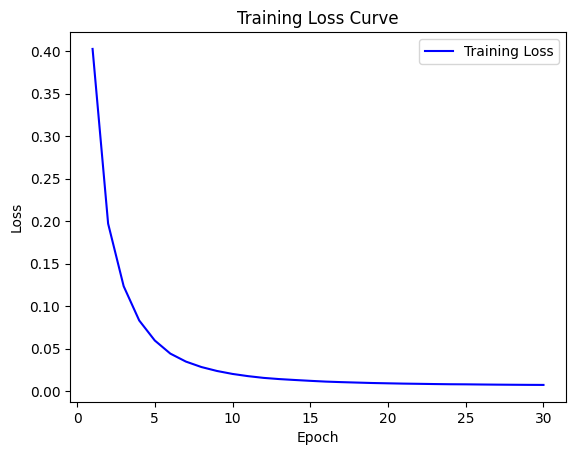

In [ ]:
# Plotting the loss curve
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [ ]:
import os
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

MAPILLARY_TOKEN = "MLY|9796955727030398|79bd541e357958deb337d6a6f6ea3f7b"

bbox = [-117.854172,33.979715,-117.822629,33.992507]  # Longitude, Latitude
DOWNLOAD_PATH = "/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data"
GREEN_IMAGES_PATH = os.path.join(DOWNLOAD_PATH, "test_images_Diamond_bar")

def search_mapillary_images(bbox, token, limit=20):
    url = "https://graph.mapillary.com/images"
    params = {
        "access_token": token,
        "bbox": ",".join(map(str, bbox)),
        "fields": "id,thumb_1024_url",
        "limit": limit
    }
    response = requests.get(url, params=params)
    data = response.json()
    return data.get("data", [])

def download_images(image_data, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for item in tqdm(image_data):
        img_url = item.get("thumb_1024_url")
        img_id = item.get("id")
        if img_url and img_id:
            img_data = requests.get(img_url).content
            with open(f"{save_dir}/{img_id}.jpg", "wb") as f:
                f.write(img_data)

def has_green(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return False
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lower_green = (25, 30, 30)
        upper_green = (95, 255, 255)
        mask = cv2.inRange(hsv, lower_green, upper_green)
        green_pixels = cv2.countNonZero(mask)
        threshold = img.shape[0] * img.shape[1] * 0.005
        return green_pixels > threshold
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return False

def filter_images_by_green(image_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_folder, filename)
            if has_green(image_path):
                output_path = os.path.join(output_folder, filename)
                os.rename(image_path, output_path)
                print(f"Image {filename} contains green and moved to {output_folder}")
            else:
                os.remove(image_path)
                print(f"Image {filename} does not contain significant green and deleted")

def show_filtered_samples(folder, num=5):
    files = glob.glob(f"{folder}/*.jpg")[:num]
    if not files:
        print(f"No images found in {folder}.")
        return
    plt.figure(figsize=(15, 5))
    for i, fpath in enumerate(files):
        img = cv2.imread(fpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(fpath))
        plt.axis("off")
    plt.show()

100%|██████████| 37/37 [00:40<00:00,  1.11s/it]


Image 1405683886544980.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/test_images_Diamond_bar
Image 2627887467511182.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/test_images_Diamond_bar
Image 2432356973738095.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/test_images_Diamond_bar
Image 2851625381805249.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/test_images_Diamond_bar
Image 1948676308662622.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/test_images_Diamond_bar
Image 1963891293809790.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/test_images_Diamond_bar
Image 1918739774993287.jpg contains green and moved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/test_images_Diamond_bar
Image 2053628511478570.jpg 

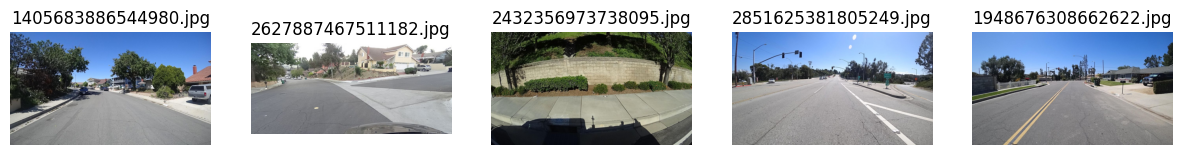

In [ ]:
# Search and download
images = search_mapillary_images(bbox, MAPILLARY_TOKEN, limit=37)
download_images(images, save_dir=DOWNLOAD_PATH)

# filter
filter_images_by_green(image_folder=DOWNLOAD_PATH, output_folder=GREEN_IMAGES_PATH)

# Display filtered image
show_filtered_samples(folder=GREEN_IMAGES_PATH)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

class GreeneryTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.image_dir, img_name.replace('.jpg', '.json'))

        # Loading images
        image = Image.open(img_path).convert('RGB')

        # Creating a mask
        mask = Image.new('L', image.size, 0)
        try:
            with open(label_path, 'r') as f:
                label_data = json.load(f)
                draw = ImageDraw.Draw(mask)
                for shape in label_data['shapes']:
                    if shape['label'] in ['green_tree', 'shrub', 'grass']:
                        points = shape['points']
                        # Ensure y1 >= y0
                        x0, y0 = min(points[0][0], points[1][0]), min(points[0][1], points[1][1])
                        x1, y1 = max(points[0][0], points[1][0]), max(points[0][1], points[1][1])
                        draw.rectangle([x0, y0, x1, y1], fill=1)
        except FileNotFoundError:
            print(f"Warning: Label file not found for {img_name}")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

def calculate_accuracy(outputs, masks):
    """Calculates pixel-level accuracy."""
    preds = (torch.sigmoid(outputs) > 0.5).float()
    correct = (preds == masks).float().sum()
    total = masks.numel()
    return correct / total

def calculate_iou(outputs, masks):
    """Calculates the Intersection over Union (IoU)."""
    preds = (torch.sigmoid(outputs) > 0.5).float()
    intersection = (preds * masks).float().sum()
    union = (preds + masks).float().sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou

In [ ]:
# Define the path to the test images
test_data_path = '/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/test_images_Diamond_bar'

# Data Augmentation for test set (only resizing and to tensor)
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Create the test dataset
test_dataset = GreeneryTestDataset(
    image_dir=test_data_path,
    transform=test_transform
)

# Create the test dataloader
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the UNet model architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        m = self.middle(p4)

        u4 = self.up4(m)
        u4 = torch.cat([u4, d4], dim=1)
        c4 = self.conv4(u4)
        u3 = self.up3(c4)
        u3 = torch.cat([u3, d3], dim=1)
        c3 = self.conv3(u3)
        u2 = self.up2(c3)
        u2 = torch.cat([u2, d2], dim=1)
        c2 = self.conv2(u2)
        u1 = self.up1(c2)
        u1 = torch.cat([u1, d1], dim=1)
        c1 = self.conv1(u1)

        return self.out(c1)
# Load the trained model
model_path = '/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/unet_greenery_segmentation.pth'
model = UNet(n_classes=1).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

criterion = nn.BCEWithLogitsLoss()

test_loss = 0.0
total_accuracy = 0.0
total_iou = 0.0
num_batches = len(test_loader)

with torch.no_grad():  # Disable gradient calculations during evaluation
    with tqdm(test_loader, desc='Evaluating', unit='batch') as pbar:
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            accuracy = calculate_accuracy(outputs, masks)
            iou = calculate_iou(outputs, masks)

            total_accuracy += accuracy.item()
            total_iou += iou.item()

            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), iou=iou.item())

avg_test_loss = test_loss / num_batches
avg_accuracy = total_accuracy / num_batches
avg_iou = total_iou / num_batches

print(f'\nTest Loss: {avg_test_loss:.4f}')
print(f'Test Accuracy: {avg_accuracy:.4f}')
print(f'Test IoU: {avg_iou:.4f}')

Evaluating: 100%|██████████| 9/9 [01:01<00:00,  6.82s/batch, accuracy=0.818, iou=1.78e-9, loss=0.0068]


Test Loss: 0.0076
Test Accuracy: 0.7798
Test IoU: 0.0000
